# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1rrJtZQ6nxC8s59-7ScbwEcNeJRh14VOk?usp=sharing

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In [3]:
pip install split-folders

In [4]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import splitfolders

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# location on drive
master_pth = '/content/gdrive/MyDrive/APS360labs/Lab3_Gestures_Summer/'
output_file = '/content/gdrive/MyDrive/APS360labs/Lab3_Gestures_Summer split/'

In [9]:
# splitting the data into 60% train, 20% validation, 20% test
splitfolders.ratio(master_pth, output=output_file, seed=12345, ratio=(.6, .2, .2))

Copying files: 2219 files [01:26, 25.63 files/s]


In [7]:
# transform settings
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor()])

# loading datasets
train_set = datasets.ImageFolder(output_file + 'train', transform=transform)
val_set = datasets.ImageFolder(output_file + 'val', transform=transform)
test_set = datasets.ImageFolder(output_file + 'test', transform=transform)

train_loader = DataLoader(train_set, batch_size=32, num_workers = 1, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, num_workers = 1, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, num_workers = 1, shuffle=True)

The data was split homogeneously with 60% of the data in the training set, 20% in validation set, and 20% in test set. Splitting the data homogeneously means that the split ratio is the same (60%, 20%, 20%) for each class of hand signs. This will help ensure a fair evaluation of our model.

### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [8]:
torch.manual_seed(12345)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "model"
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 26 * 26, 64)
        self.fc2 = nn.Linear(64, 9)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64*26*26)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

I chose a CNN architecture because we are working with images. I used 3 convolutional layers, 1 pooling layer, and 2 fully connected layers. I chose to use 3 convolutional layers with their respective output channels because I wanted to extract more abstract features; I also found that those values were commonly used and wanted to test them out. Finally, I used the ReLU activation function to introduce non-linearity.

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [12]:
def train(model, train_loader, val_loader, batch_size = 128, num_epochs = 20, learning_rate = 0.01):
  torch.manual_seed(12345)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set up some numpy arrays to store the accuracy
  train_err = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  val_err = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)

# looping over the dataset
  for epoch in range(num_epochs):
    total_train_err = 0.0
    total_train_loss = 0.0
    total_epoch = 0
    for i, (img, labels) in enumerate(train_loader):

      if torch.cuda.is_available():
        img, labels = img.cuda(), labels.cuda()

#forward pass, backward pass, optimize
      outputs = model(img)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

# computing the train loss and error
      total_train_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total_train_err += (predicted != labels).sum().item()
      total_epoch += labels.size(0)

# calculating the error and loss averages and appending to the arrays
    train_err[epoch] = float(total_train_err/total_epoch)
    train_loss[epoch] = float(total_train_loss/(len(train_loader)))
    val_err[epoch], val_loss[epoch] = evaluate(model, val_loader, criterion)

    print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
# Save the current model (checkpoint) to a file
    model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
    torch.save(model.state_dict(), model_path)

  print('Finished Training')

# Write the train/test loss/err into CSV file for plotting later
  epochs = np.arange(1, num_epochs + 1)
  np.savetxt("{}_train_err.csv".format(model_path), train_err)
  np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
  np.savetxt("{}_val_err.csv".format(model_path), val_err)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

  plot_training_curve(model_path)

# helper functions - referencing lab 2
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

    Args:
        net: PyTorch neural network object
        loader: PyTorch data loader for the validation set
        criterion: The loss function
    Returns:
        err: A scalar for the avg classification error over the validation set
        loss: A scalar for the average loss function over the validation set
    """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0

    for i, (img, labels) in enumerate(loader):

      if torch.cuda.is_available():
        img, labels = img.cuda(), labels.cuda()

      outputs = net(img)
      loss = criterion(outputs, labels)

      # Computing the loss and error
      total_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total_err += (predicted != labels).sum().item()
      total_epoch += labels.size(0)

    # Calculate loss and error averages
    err = total_err / total_epoch
    loss = total_loss / (len(loader))

    return err, loss

# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

I chose the cross entropy loss function because it works well for classification problems. For the optimizer, I used Adam because it is one that we've seen througout lectures, but not as much in labs, so I wanted to try it out of curiosity and see how it would perform compared to the usual SGD we use.

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [78]:
# constructed a small dataset on google drive with the following path
small_pth = '/content/gdrive/MyDrive/APS360labs/Lab3_Gestures_Summer split/small'
# transform settings
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor()])

# loading dataset
small_set = datasets.ImageFolder(small_pth, transform=transform)

small_loader = DataLoader(small_set, batch_size=3, num_workers = 1, shuffle=True)

Epoch 1: Train err: 0.9629629629629629, Train loss: 2.368751645088196 |Validation err: 0.8888888888888888, Validation loss: 2.199771271811591
Epoch 2: Train err: 0.9259259259259259, Train loss: 2.2030197514428034 |Validation err: 0.7037037037037037, Validation loss: 2.183058155907525
Epoch 3: Train err: 0.8518518518518519, Train loss: 2.1887771553463407 |Validation err: 0.8888888888888888, Validation loss: 2.154680464002821
Epoch 4: Train err: 0.8518518518518519, Train loss: 2.171040508482191 |Validation err: 0.7407407407407407, Validation loss: 2.1254819764031305
Epoch 5: Train err: 0.5555555555555556, Train loss: 2.084897610876295 |Validation err: 0.6296296296296297, Validation loss: 2.0046135981877646
Epoch 6: Train err: 0.7777777777777778, Train loss: 2.078968948788113 |Validation err: 0.3333333333333333, Validation loss: 1.837225317955017
Epoch 7: Train err: 0.48148148148148145, Train loss: 1.7896802292929754 |Validation err: 0.4444444444444444, Validation loss: 1.5250180297427707

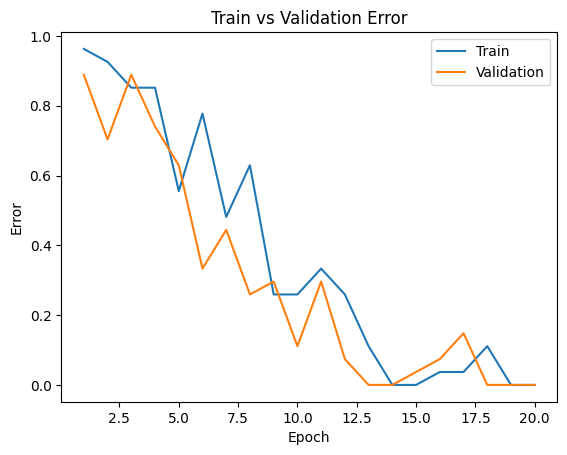

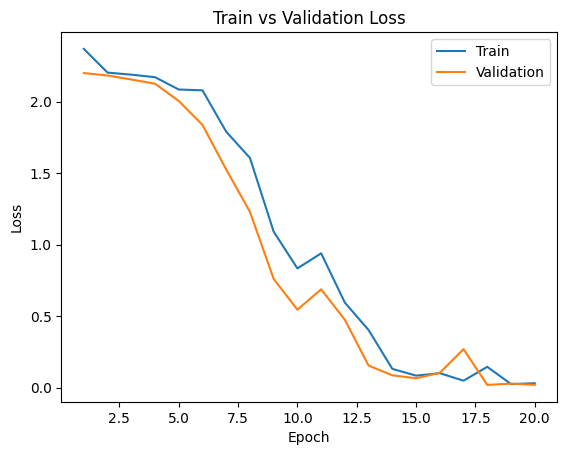

In [79]:
model = CNN()
train(model, small_loader, small_loader, batch_size = 27, num_epochs = 20, learning_rate = 0.001)

We can see that the error is 0.0, meaning we achieved a 100% accuracy on the small dataset. This shows that our model has memorized the training data.

### 3. Hyperparameter Search [15 pt]

### Part (a) - 3 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.



*   Batch size
*   Number of hidden units
*   Learning rate





### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

Epoch 1: Train err: 0.8675696012039127, Train loss: 2.8763083787191484 |Validation err: 0.7068181818181818, Validation loss: 2.028642858777727
Epoch 2: Train err: 0.582392776523702, Train loss: 1.6279472907384236 |Validation err: 0.47045454545454546, Validation loss: 1.5112246189798628
Epoch 3: Train err: 0.4507148231753198, Train loss: 1.3171143957546778 |Validation err: 0.3886363636363636, Validation loss: 1.0652659365109034
Epoch 4: Train err: 0.3333333333333333, Train loss: 1.0282268637702578 |Validation err: 0.2772727272727273, Validation loss: 0.8538044095039368
Epoch 5: Train err: 0.3220466516177577, Train loss: 0.8950140689100538 |Validation err: 0.2727272727272727, Validation loss: 0.8246122513498578
Epoch 6: Train err: 0.309255079006772, Train loss: 0.8598282223656064 |Validation err: 0.30454545454545456, Validation loss: 0.9101037681102753
Epoch 7: Train err: 0.236267870579383, Train loss: 0.7155055836552665 |Validation err: 0.25681818181818183, Validation loss: 0.8384264622

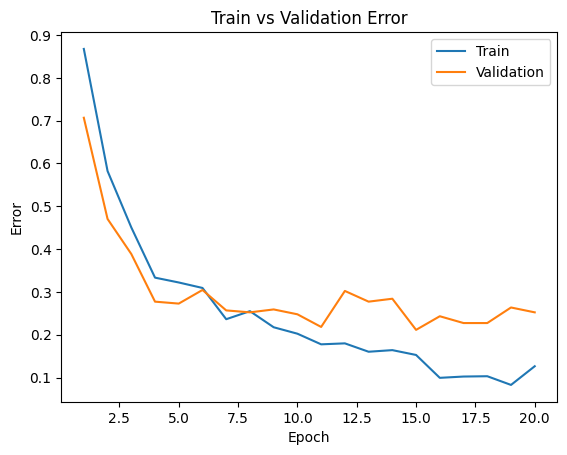

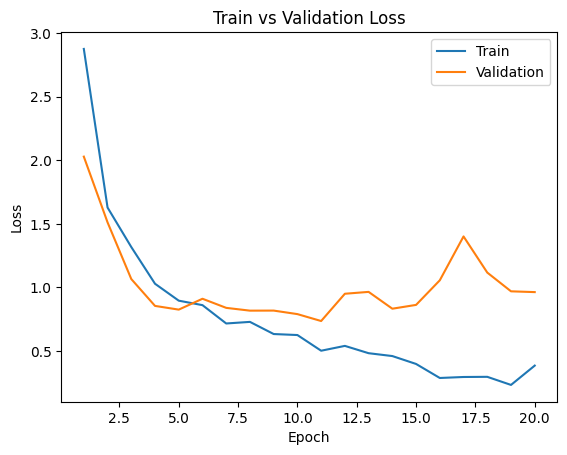

In [72]:
# using the default hyperparameters
model = CNN()
train(model, train_loader, val_loader, batch_size = 128, num_epochs = 20, learning_rate = 0.01)

Epoch 1: Train err: 0.890895410082769, Train loss: 2.391541532107762 |Validation err: 0.8863636363636364, Validation loss: 2.1973991053444997
Epoch 2: Train err: 0.8886380737396539, Train loss: 2.1988197905676707 |Validation err: 0.8863636363636364, Validation loss: 2.196995973587036
Epoch 3: Train err: 0.9014296463506396, Train loss: 2.1988899878093173 |Validation err: 0.8886363636363637, Validation loss: 2.197163871356419
Epoch 4: Train err: 0.8871331828442438, Train loss: 2.1986971355619884 |Validation err: 0.8863636363636364, Validation loss: 2.197129096303667
Epoch 5: Train err: 0.8954100827689992, Train loss: 2.1982566175006686 |Validation err: 0.8863636363636364, Validation loss: 2.1971499749592374
Epoch 6: Train err: 0.8886380737396539, Train loss: 2.198777613185701 |Validation err: 0.8886363636363637, Validation loss: 2.197299804006304
Epoch 7: Train err: 0.9029345372460497, Train loss: 2.199087597074963 |Validation err: 0.8886363636363637, Validation loss: 2.1973539931433543


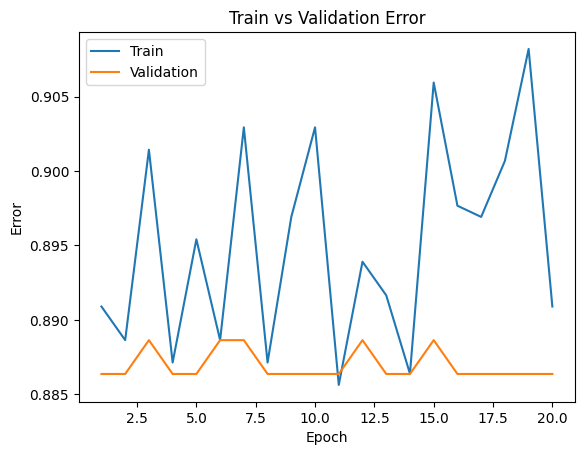

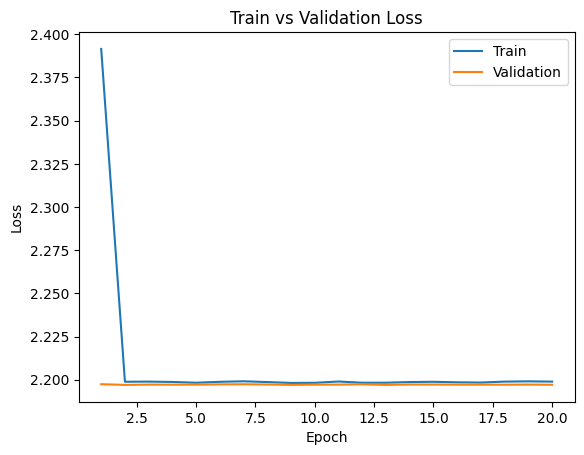

In [11]:
# increasing the batch size
model_2 = CNN()
train(model_2, train_loader, val_loader, batch_size = 512, num_epochs = 20, learning_rate = 0.01)

Epoch 1: Train err: 0.7072987208427389, Train loss: 1.9189520790463401 |Validation err: 0.4113636363636364, Validation loss: 1.283792563847133
Epoch 2: Train err: 0.41008276899924756, Train loss: 1.2110503415266674 |Validation err: 0.33181818181818185, Validation loss: 0.9949032621724265
Epoch 3: Train err: 0.326561324303988, Train loss: 1.0102599504448118 |Validation err: 0.2681818181818182, Validation loss: 0.8899170500891549
Epoch 4: Train err: 0.27313769751693, Train loss: 0.8685997085911887 |Validation err: 0.24772727272727274, Validation loss: 0.822766295501164
Epoch 5: Train err: 0.24905944319036868, Train loss: 0.7561917170172646 |Validation err: 0.27045454545454545, Validation loss: 0.816377831356866
Epoch 6: Train err: 0.2234762979683973, Train loss: 0.6580693303119569 |Validation err: 0.22272727272727272, Validation loss: 0.8058234261614936
Epoch 7: Train err: 0.16478555304740405, Train loss: 0.5024574548006058 |Validation err: 0.25, Validation loss: 0.8152662622077125
Epoch

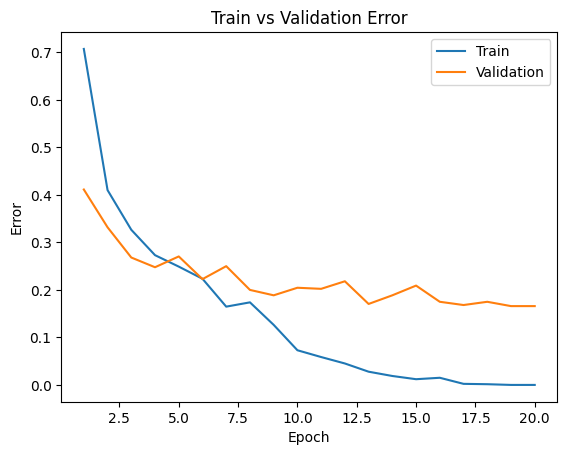

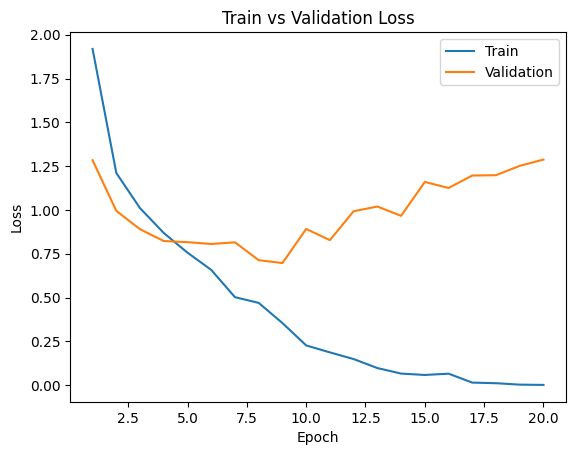

In [13]:
# that didn't work well, so we'll go back to the original and try decreasing the learning rate to better learn the features
model_3 = CNN()
train(model_3, train_loader, val_loader, batch_size = 128, num_epochs = 20, learning_rate = 0.001)

In [14]:
# The model is overfitting very early on, so our learning rate was probably too small
# We can try changing the number of hidden units and increasing the learning rate by a bit
torch.manual_seed(12345)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "model"
        self.conv1 = nn.Conv2d(3, 5, 3)
        self.conv2 = nn.Conv2d(5, 10, 3)
        self.conv3 = nn.Conv2d(10, 15, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(15 * 26 * 26, 64)
        self.fc2 = nn.Linear(64, 9)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 15*26*26)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch 1: Train err: 0.8878856282919488, Train loss: 2.2020915122259233 |Validation err: 0.8909090909090909, Validation loss: 2.1974174124853953
Epoch 2: Train err: 0.90895410082769, Train loss: 2.1986937693187167 |Validation err: 0.8863636363636364, Validation loss: 2.197152614593506
Epoch 3: Train err: 0.8991723100075244, Train loss: 2.198400139808655 |Validation err: 0.8863636363636364, Validation loss: 2.1972417320523943
Epoch 4: Train err: 0.8856282919488337, Train loss: 2.1980996302195956 |Validation err: 0.8863636363636364, Validation loss: 2.1971555096762523
Epoch 5: Train err: 0.8976674191121143, Train loss: 2.197830943834214 |Validation err: 0.8863636363636364, Validation loss: 2.197081054959978
Epoch 6: Train err: 0.8893905191873589, Train loss: 2.1982977333522977 |Validation err: 0.8886363636363637, Validation loss: 2.197257944515773
Epoch 7: Train err: 0.9029345372460497, Train loss: 2.198252252170018 |Validation err: 0.8863636363636364, Validation loss: 2.19723801953452
Ep

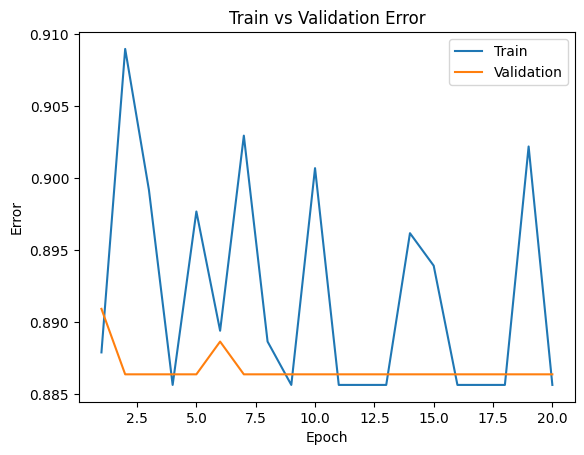

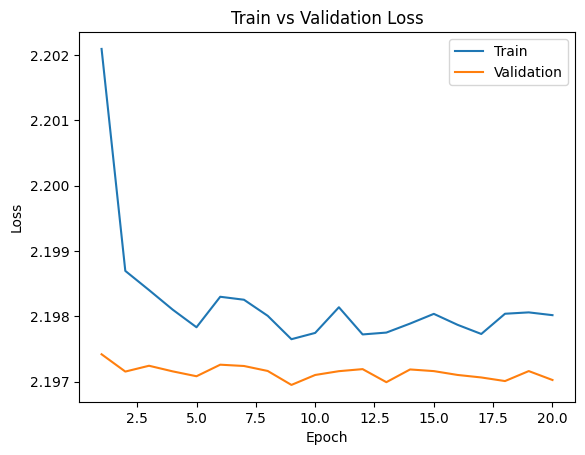

In [15]:
model_4 = CNN()
train(model_4, train_loader, val_loader, batch_size = 128, num_epochs = 20, learning_rate = 0.005)

In [17]:
# That didn't work well (the model is not able to generalize the data)
# We can try changing the number of hidden units again
torch.manual_seed(12345)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "model"
        self.conv1 = nn.Conv2d(3, 5, 3)
        self.conv2 = nn.Conv2d(5, 10, 3)
        self.conv3 = nn.Conv2d(10, 25, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(25 * 26 * 26, 64)
        self.fc2 = nn.Linear(64, 9)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 25*26*26)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch 1: Train err: 0.6982693754702785, Train loss: 1.9037492332004367 |Validation err: 0.4772727272727273, Validation loss: 1.3469117965017046
Epoch 2: Train err: 0.43190368698269377, Train loss: 1.2331525356996627 |Validation err: 0.35, Validation loss: 1.0108117844377245
Epoch 3: Train err: 0.3295711060948081, Train loss: 0.9968943326246171 |Validation err: 0.3477272727272727, Validation loss: 0.9975700165544238
Epoch 4: Train err: 0.3054928517682468, Train loss: 0.8738750290303003 |Validation err: 0.275, Validation loss: 0.8275793875966754
Epoch 5: Train err: 0.2693754702784048, Train loss: 0.7974117086047218 |Validation err: 0.3477272727272727, Validation loss: 1.1095011915479387
Epoch 6: Train err: 0.2580887885628292, Train loss: 0.7384643973339171 |Validation err: 0.21818181818181817, Validation loss: 0.7912423099790301
Epoch 7: Train err: 0.18961625282167044, Train loss: 0.5440094321966171 |Validation err: 0.24772727272727274, Validation loss: 0.8537756204605103
Epoch 8: Train 

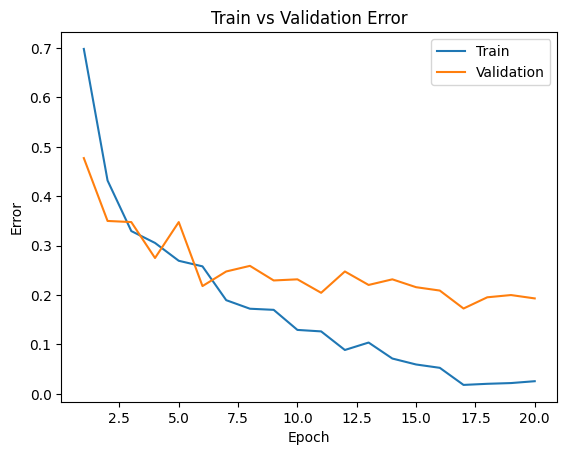

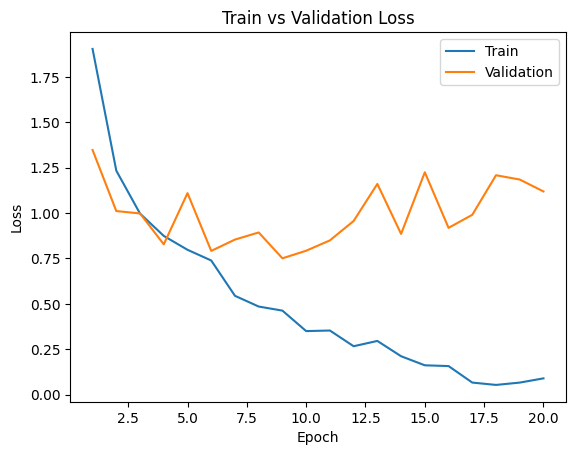

In [18]:
model_5 = CNN()
train(model_5, train_loader, val_loader, batch_size = 128, num_epochs = 20, learning_rate = 0.005)

In [21]:
# Changing the number of hidden units again
torch.manual_seed(12345)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "model"
        self.conv1 = nn.Conv2d(3, 5, 3)
        self.conv2 = nn.Conv2d(5, 10, 3)
        self.conv3 = nn.Conv2d(10, 25, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(25 * 26 * 26, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 25*26*26)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch 1: Train err: 0.8457486832204665, Train loss: 2.172223760968163 |Validation err: 0.7136363636363636, Validation loss: 1.9132936682019914
Epoch 2: Train err: 0.5771256583897667, Train loss: 1.6058564015797205 |Validation err: 0.39545454545454545, Validation loss: 1.1246635062353951
Epoch 3: Train err: 0.3897667419112114, Train loss: 1.1471928868974959 |Validation err: 0.3477272727272727, Validation loss: 1.028121565069471
Epoch 4: Train err: 0.33860045146726864, Train loss: 0.9798039765585036 |Validation err: 0.325, Validation loss: 0.9703757124287742
Epoch 5: Train err: 0.3258088788562829, Train loss: 0.9397784457320258 |Validation err: 0.32727272727272727, Validation loss: 0.9327970487730843
Epoch 6: Train err: 0.28592927012791575, Train loss: 0.8301643516336169 |Validation err: 0.29545454545454547, Validation loss: 0.9316025674343109
Epoch 7: Train err: 0.27840481565086533, Train loss: 0.7778792686405636 |Validation err: 0.25227272727272726, Validation loss: 0.9072859755584172


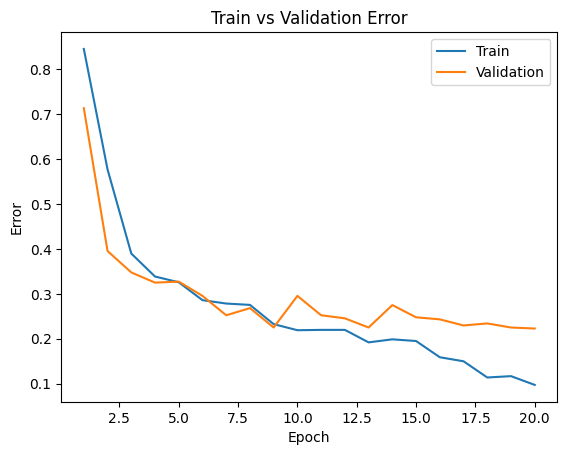

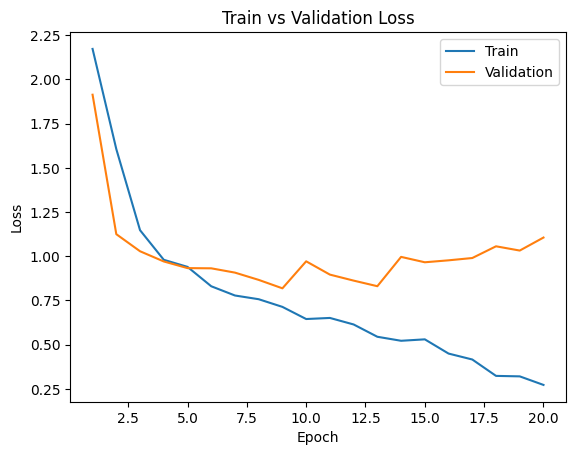

In [20]:
model_6 = CNN()
train(model_6, train_loader, val_loader, batch_size = 128, num_epochs = 20, learning_rate = 0.005)

Epoch 1: Train err: 0.8939051918735892, Train loss: 2.2061880145754134 |Validation err: 0.8863636363636364, Validation loss: 2.1989107642854964
Epoch 2: Train err: 0.8397291196388262, Train loss: 2.153980831305186 |Validation err: 0.7204545454545455, Validation loss: 1.9976311070578439
Epoch 3: Train err: 0.6621519939804364, Train loss: 1.7744645845322382 |Validation err: 0.6068181818181818, Validation loss: 1.5312368018286568
Epoch 4: Train err: 0.5221971407072987, Train loss: 1.4112763149397713 |Validation err: 0.44772727272727275, Validation loss: 1.2379379442759924
Epoch 5: Train err: 0.44996237772761477, Train loss: 1.255914377314704 |Validation err: 0.41818181818181815, Validation loss: 1.2011476797716958
Epoch 6: Train err: 0.3912716328066215, Train loss: 1.1633571911425817 |Validation err: 0.35454545454545455, Validation loss: 1.0921934459890639
Epoch 7: Train err: 0.3649360421369451, Train loss: 1.076636098680042 |Validation err: 0.33181818181818185, Validation loss: 1.0373177

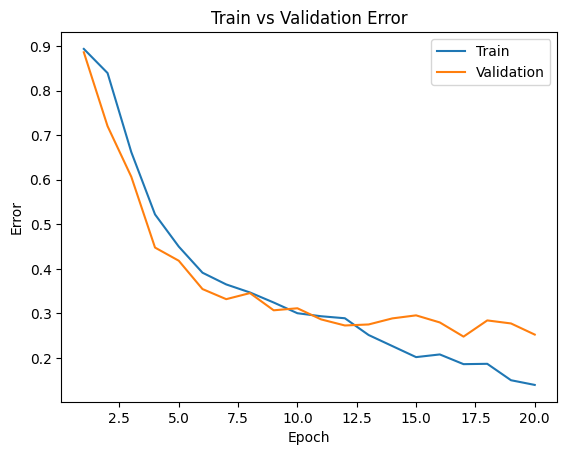

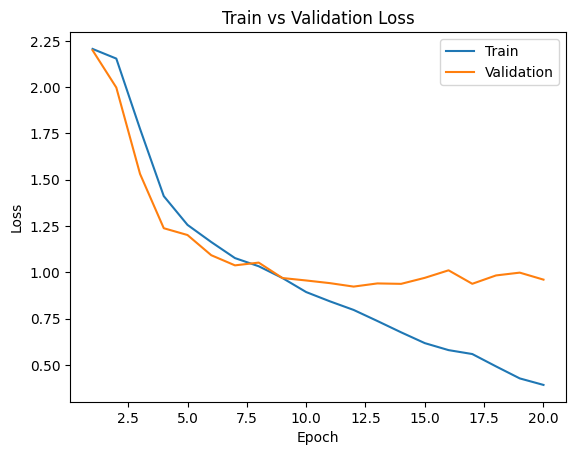

In [24]:
# decreasing the learning rate
model_7 = CNN()
train(model_7, train_loader, val_loader, batch_size = 128, num_epochs = 20, learning_rate = 0.001)

### Part (c) - 3 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

Out of all the models, I think the first and 7th model performed the best because even though they might not have reached the lowest training error, they are not as severely overfit as some of the other models. I'll choose the 7th model because it takes much less time to train while still giving similar results to the first model. It is also less noisy than the first model.

### Part (d) - 4 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [26]:
model_path = get_model_name(model_7.name, 128, 0.001, 19)
state = torch.load(model_path)
model_7.load_state_dict(state)

criterion = nn.CrossEntropyLoss()
test_err, test_loss = evaluate(model_7, test_loader, criterion)
print("Test error: {}, Test loss: {}".format(test_err, test_loss))

Test error: 0.28888888888888886, Test loss: 0.9398359964291255


The test accuracy is 71%.

### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [27]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 95.7MB/s]


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [29]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
#features = alexnet.features(img)

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [96]:
# empty lists for train, val, and test sets
train_features_list = []
val_features_list = []
test_features_list = []

# function that computes the features
def alexnet_features(img):
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())
  return features_tensor

# computing the features and saving them in respective lists
for img, label in train_loader:
  features = alexnet_features(img)
  train_features_list.append((features, label))

for img, label in val_loader:
  features = alexnet_features(img)
  val_features_list.append((features, label))

for img, label in test_loader:
  features = alexnet_features(img)
  test_features_list.append((features, label))

# loading the data
train_feature_loader = DataLoader(train_features_list, shuffle=True)
val_feature_loader = DataLoader(val_features_list, shuffle=True)
test_feature_loader = DataLoader(test_features_list, shuffle=True)

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [103]:
torch.manual_seed(12345)
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.name = "model"
        self.fc1 = nn.Linear(256 * 6 *6, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, img):
        x = img.view(-1, 256* 6 *6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

I used 2 fully connected layers because we are using pretrained weights from AlexNet and I don't want to make the neural network too complex/deep. I was also simply curious what the effect of no convolutional layers would have if we are using pretrained weights. I kept with the same amount of hidden units and activation function (ReLU) that worked for the CNN model_7 to see how they would perform with the AlexNet features.

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [99]:
def train(model, train_loader, val_loader, batch_size = 128, num_epochs = 20, learning_rate = 0.01):
  torch.manual_seed(12345)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set up some numpy arrays to store the accuracy
  train_err = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  val_err = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)

# looping over the dataset
  for epoch in range(num_epochs):
    total_train_err = 0.0
    total_train_loss = 0.0
    total_epoch = 0
    for i, (img, labels) in enumerate(train_loader):
      if torch.cuda.is_available():
        img, labels = img.cuda(), labels.cuda()
      labels = labels.view(-1)
#forward pass, backward pass, optimize
      outputs = model(img)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

# computing the train loss and error
      total_train_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total_train_err += (predicted != labels).sum().item()
      total_epoch += labels.size(0)

# calculating the error and loss averages and appending to the arrays
    train_err[epoch] = float(total_train_err/total_epoch)
    train_loss[epoch] = float(total_train_loss/(len(train_loader)))
    val_err[epoch], val_loss[epoch] = evaluate(model, val_loader, criterion)

    print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
# Save the current model (checkpoint) to a file
    model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
    torch.save(model.state_dict(), model_path)

  print('Finished Training')

# Write the train/test loss/err into CSV file for plotting later
  epochs = np.arange(1, num_epochs + 1)
  np.savetxt("{}_train_err.csv".format(model_path), train_err)
  np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
  np.savetxt("{}_val_err.csv".format(model_path), val_err)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

  plot_training_curve(model_path)

# helper functions - referencing lab 2
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

    Args:
        net: PyTorch neural network object
        loader: PyTorch data loader for the validation set
        criterion: The loss function
    Returns:
        err: A scalar for the avg classification error over the validation set
        loss: A scalar for the average loss function over the validation set
    """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0

    for i, (img, labels) in enumerate(loader):

      if torch.cuda.is_available():
        img, labels = img.cuda(), labels.cuda()
      labels = labels.view(-1)
      outputs = net(img)
      loss = criterion(outputs, labels)

      # Computing the loss and error
      total_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total_err += (predicted != labels).sum().item()
      total_epoch += labels.size(0)

    # Calculate loss and error averages
    err = total_err / total_epoch
    loss = total_loss / (len(loader))

    return err, loss

# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

Epoch 1: Train err: 0.3468773513920241, Train loss: 1.094493763787406 |Validation err: 0.13863636363636364, Validation loss: 0.5118935129472187
Epoch 2: Train err: 0.09932279909706546, Train loss: 0.3957166973324049 |Validation err: 0.07272727272727272, Validation loss: 0.3039031635437693
Epoch 3: Train err: 0.04890895410082769, Train loss: 0.20841255766295252 |Validation err: 0.06363636363636363, Validation loss: 0.24136241525411606
Epoch 4: Train err: 0.013544018058690745, Train loss: 0.11326545645438489 |Validation err: 0.05227272727272727, Validation loss: 0.21558980271220207
Epoch 5: Train err: 0.004514672686230248, Train loss: 0.06521804404578038 |Validation err: 0.04772727272727273, Validation loss: 0.19397571789366858
Epoch 6: Train err: 0.0, Train loss: 0.04050131146574304 |Validation err: 0.045454545454545456, Validation loss: 0.1852482669055462
Epoch 7: Train err: 0.0, Train loss: 0.028783297776022836 |Validation err: 0.045454545454545456, Validation loss: 0.1871016600302287

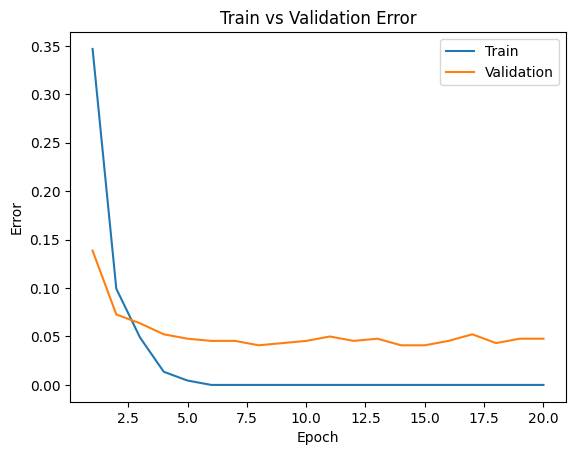

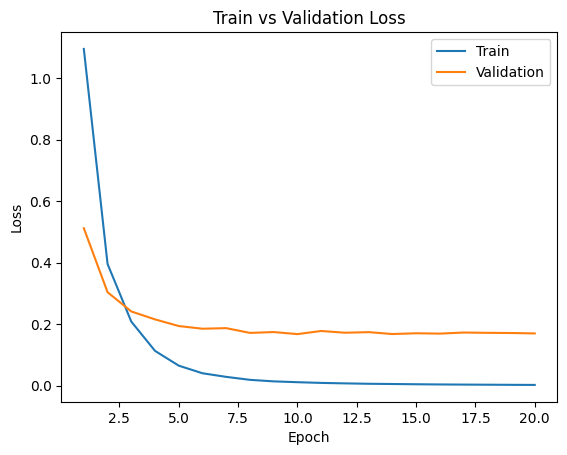

In [104]:
model = AlexNet()
train(model, train_feature_loader, val_feature_loader, batch_size = 128, num_epochs = 20, learning_rate = 0.001)

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [114]:
model_path = get_model_name(model.name, 128, 0.001, 19)
state = torch.load(model_path)
model.load_state_dict(state)

criterion = nn.CrossEntropyLoss()
test_err, test_loss = evaluate(model, test_feature_loader, criterion)
print("Test error: {}, Test loss: {}".format(test_err, test_loss))

Test error: 0.04888888888888889, Test loss: 0.13119214985053987


The best model has a test accuracy of 95%. In comparison to the CNN model without transfer learning which had a test accuracy of 71%, the model using transfer learning is clearly superior (95% is much better than 71%). Though my AlexNet model was simpler (less layers), it still performed better than my CNN model which was much more deep; this shows that the pretrained weights from AlexNet improved/helped the accuracy of my model.